### Getting set up

First, we must load the dataframe.

In [1]:
%matplotlib inline
import pandas as pd
df = pd.read_pickle('unpack_benchmark.dataframe')

We first seek to evaluate linearity (in the number of iterations). We can evaluate this for a given parameter configuration in the following way. First, we define a filtering dictionary used to constrain the dataframe.

In [2]:
filter_dict = {
    'access_pattern': 'independent',
    'complexity': 'complex',
    'column': 'nocolumn',
    'type': 'std::tuple<double, double, double, double>',
    'orientation': 'soa',
    'container_size': 1048576
}

Before we actually filter the dataset, we can take a look at the type of data which will be returned.

In [3]:
import df_plot as D
import pprint
pp = pprint.PrettyPrinter(indent=2)
unique = D.unique_set(df)
pp.pprint(D.get_selection_type(unique, filter_dict))

Querying with this filter will yield data with these dimensions unspecified:

{ 'benchmarking_tool': array(['chrono_benchmark'], dtype=object),
  'compiler': array(['g++-7.1'], dtype=object),
  'container': array(['vector'], dtype=object),
  'iterations': array([  32768,      32,       1, 1048576,    1024]),
  'optimization': array(['O3'], dtype=object),
  'run_id': array(['1'], dtype=object),
  'system_memory': array(['64GB'], dtype=object),
  'system_os': array(['Red Hat Enterprise Linux Server 6.9 (Santiago)'], dtype=object),
  'system_processor': array(['Intel(R) Xeon(R) CPU E5-2680 @ 2.70GHz'], dtype=object)}


### Testing for linearity through iterations (single case)

We can see in this case the only dimension with size of more than 1 is iterations. This is exctly what we want for assessing linearity (or lack thereof) through this dimension. Let's go ahead and filter our dataframe and determine a best fit line for the data.

x: [1, 32, 1024, 32768]
y: [0.09778025, 2.4766686, 73.359947, 2497.6101]
R2 score: 0.99999670
An R2 of 1 is a perfect fit. Range: (-infty, 1]
[ -1.44992140e+00   9.14280422e-01   7.65687388e+01   2.49751141e+03]


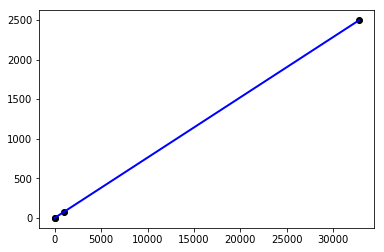

0.99999669929374169

In [4]:
selection = D.filter_df(filter_dict, df)
x, y = D.xy(selection, 'iterations', 'timing', sortx=True)
print('x: ' + str(x))
print('y: ' + str(y))
D.linearity_test(x, y, show_output=True)

This shows how linearity testing will work for each configuration. We'll now go through to verify that every configuration displays the same type of linearity.

### Testing for linearity through iterations (all configurations)

In [5]:
# this takes > an hour
# df_plot.linearity_test_all(unique, df, test_dimension='iterations') 

##### What this means...

Because all of these parameter configurations are showing an essentially perfect linear fit, we can proceed with analysis using only the highest iteration data points. These high iteration configurations will have the least noise and we won't lose any information from the lower iteration configurations.

### Testing for linearity through container size (single configuration)

Now that we've established we can look at solely the highest iteration data points, let's take a look at container size and verify we see the same type of linearity there.


x: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
y: [0.07234747, 0.14149547, 0.27709749, 0.56644583, 1.1007181, 2.1939662, 4.4165416, 8.7795639, 17.571589, 35.182793, 70.267639, 141.51245, 283.14798, 569.94684, 1183.4451, 2449.3101]
R2 score: 0.99956011
An R2 of 1 is a perfect fit. Range: (-infty, 1]
[ -5.92746475e+00  -5.85324549e+00  -5.70480696e+00  -5.40792990e+00
  -4.81417577e+00  -3.62666753e+00  -1.25165105e+00   3.49838191e+00
   1.29984478e+01   3.19985797e+01   6.99988434e+01   1.45999371e+02
   2.98000426e+02   6.02002536e+02   1.21000676e+03   2.42601519e+03]


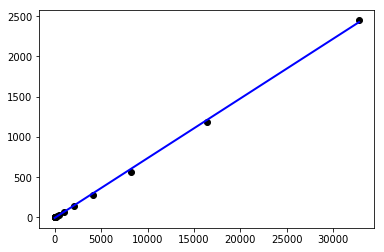

0.99956011129361877

In [6]:
filter_dict = {
    'access_pattern': 'independent',
    'complexity': 'complex',
    'column': 'nocolumn',
    'type': 'std::tuple<double, double, double, double>',
    'orientation': 'soa',
    'iterations': 1048576
}
selection = D.filter_df(filter_dict, df)
x, y = D.xy(selection, 'container_size', 'timing', sortx=True)
print('x: ' + str(x))
print('y: ' + str(y))
D.linearity_test(x, y, show_output=True)

### Testing for linearity through container size (all iterations)

In [7]:
# this takes > an hour
# df_plot.linearity_test_all(unique, df, test_dimension='container_size')

##### What this means...

We've now verified that we can do further analysis considering only the highest container size data points. 

### Comparing SoA/AoS

For this experiment, we'll use iterations per second as a sort of timing normalizer so we can better compare varying parameter configurations.



{'soa': {'x': [1, 2, 4, 8], 'y': [52.765556, 88.750084, 67.265747, 68.709785]}, 'aos': {'x': [1, 2, 4, 8], 'y': [53.96986, 82.907639, 319.79721, 142.1256]}}


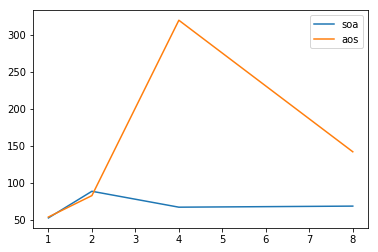

In [9]:
# need this to get the experiment's filter set
must_haves = {
    'container_size': 1048576,
    'access_pattern': 'single',
    'complexity': 'simple',
    'column': 'nocolumn',
    'iterations': 32768
}
let_vary = ['orientation']
filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
allowed_types = D.make_tuple_types('int', [1,2,4,8])
filter_dicts = D.constrain_types(filter_dicts, allowed_types)
selection = D.multi_filter_df(filter_dicts, df)
selection = D.numeric_types(selection)
multi_xy = D.multi_xy(selection, 'type', 'timing', 'orientation', sortx=True)
print(multi_xy)
D.multi_line_plot(multi_xy)